# High-dimensional data manipulation


> **Skills to take away**
>
> - *Basic*: Computation along each axis, distance computation, plotting of n-dim arrays
> - *Medium*: Find closest elements along a direction, select pairs based on their distance
> - *Expert*: Pairing objects along a given dimension 


## Introduction

The present chapter makes use of the concepts previously introduced to perform computations that one would do with high-dimensional data. Typically, if a given dataset consists of several 3D positions for each observation, one has to deal with many numbers. It is possible that grouping these vectors by pairs is relevant to understand the problem. Or maybe other operations within these various 3D vectors are useful. Since we want to use the full power of NumPy, all these computations cannot be done with an explicit loop over observations and/or over vectors. 

This chapter considers a few of these typical use cases and their implementation using NumPy, using a simple toy dataset made by hand. Most likely, you will never face such a situation for a machine learning algorithm, but it is good to go through these examples to show some of the limitations of not being able to loop over observations. 

Let's first perform the usual imports:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Then, one can set up the default Matplotlib style for all following plots. More details on available options can be found in [how to customize Matplotlib](https://matplotlib.org/users/customizing.html).

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

## Data model and goals

We consider 1 million observations, each defined by ten 3D vectors $(r_0,...,r_9)$ where $r_i=(x,y,z)$ (arrow for vector will be omitted from now on). These pseudo-data can represent positions in space or RGB colors for an image. This is just an example to play with and apply NumPy concepts for both simple computations (element-by-element functions, statistics calculations) and more complex computations exploiting the multi-dimensional structure of the data. For example, one might want to compute the distance between all pairs $(r_i, r_j)$, which has to be done without a loop.

Using the `np.random` module, it is possible to generate n-dimensional arrays easily. In our case, we want to generate an array containing our observations with 3 dimensions (or *axes* in NumPy language), and the size along each of these axes will have the following value and meaning:

- `axis=0`: over 1 million events
- `axis=1`: over 10 vectors
- `axis=2`: over 3 coordinates

In [3]:
r = np.random.random_sample((1000000, 10, 3))

It is possible to print the first two observations as follows:

In [4]:
print(r[0:2])

[[[0.01789452 0.66209367 0.06888675]
  [0.39922964 0.87771381 0.01192809]
  [0.88259998 0.88655328 0.30233561]
  [0.53178797 0.69359593 0.05459176]
  [0.69979407 0.82627363 0.63028438]
  [0.19121361 0.80913874 0.2813931 ]
  [0.22248198 0.78734303 0.39821198]
  [0.41256443 0.81143611 0.71874392]
  [0.10597153 0.61954029 0.15438807]
  [0.0586176  0.5567407  0.19918271]]

 [[0.36893905 0.29645313 0.64392255]
  [0.6084518  0.71718717 0.18079204]
  [0.79397165 0.75437849 0.81858946]
  [0.28424271 0.32153672 0.29690342]
  [0.62484107 0.23856055 0.4057989 ]
  [0.72375291 0.77319732 0.68777312]
  [0.98876848 0.32340734 0.49148584]
  [0.55165453 0.02655616 0.65149546]
  [0.42893549 0.25157921 0.26770818]
  [0.60597909 0.79425594 0.24029925]]]


## Mean over the different axes

### Mean over observations (axis=0)

This mean will average all observations, i.e., over the first dimension, returning an array of dimension `(10, 3)` corresponding to the average $r_{i}=(x_i,y_i,z_i)$ over the observations.

In [5]:
m0 = np.mean(r, axis=0)
print(m0.shape)

(10, 3)


Note the computation time of 30 ms for 30 averages over a million numbers.

In [6]:
%timeit np.mean(r, axis=0)

33.8 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


While it takes 10 times longer for a single mean over a million numbers with an explicit loop, the gain of vectorization is a factor of 300.

In [7]:
def explicit_loop(array):
    res=0
    for a in array:
        res += a/len(array)

%timeit explicit_loop(np.random.random_sample(size=1000000))

328 ms ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The distributions of `m0` obtained with `plt.hist()` result in three separate histograms (one for each $x,y,z$), each having 10 entries (one per $r_i$).

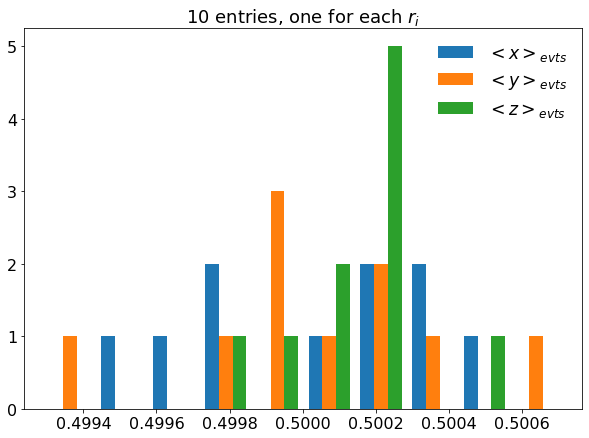

In [8]:
plt.hist(m0, label=['$<x>_{evts}$', '$<y>_{evts}$', '$<z>_{evts}$'])
plt.title('10 entries, one for each $r_i$')
plt.legend();

### Mean over the 10 vectors (axis=1)

This one will compute the average over the 10 vectors for each observation, resulting in a `(1000000, 3)` shaped array as shown below. This represents the 3D barycenter of each observation.

In [9]:
m1 = np.mean(r, axis=1)
print(m1.shape)

(1000000, 3)


One can plot the obtained array `m1` using `plt.hist()`, which results in 3 histograms, each with a million entries:

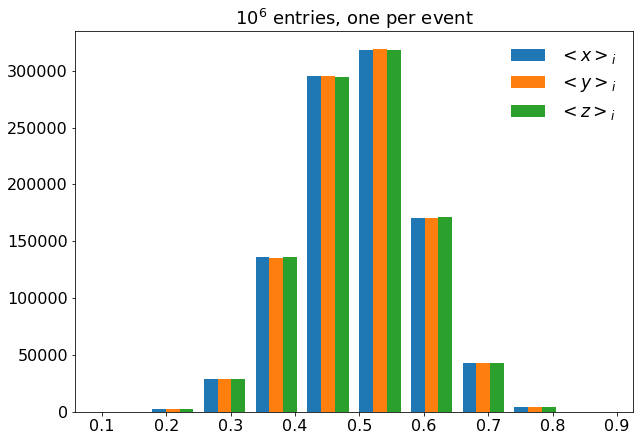

In [10]:
plt.hist(m1, label=['$<x>_{i}$', '$<y>_{i}$', '$<z>_{i}$'])
plt.title('$10^6$ entries, one per event')
plt.legend();

### Mean over the coordinates (`axis=2`)

This directly computes the average over the three coordinates $(x+y+z)/3$ for each vector of each event, resulting in 10 values per event.

In [11]:
m2 = np.mean(r, axis=2)
print(m2.shape)

(1000000, 10)


The `plt.hist()` of the resulting array `m2` corresponds to 10 histograms, each with a million entries.

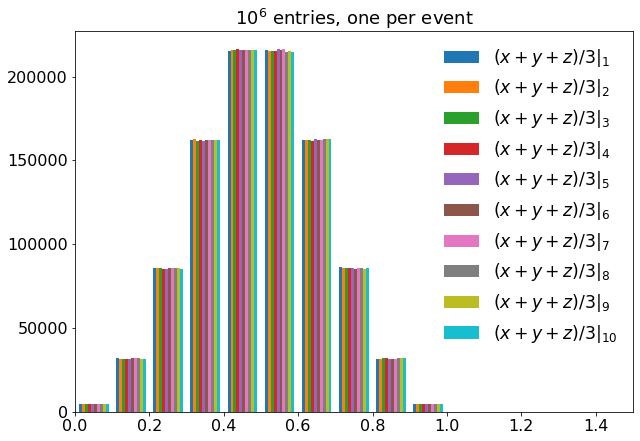

In [12]:
names = ['$(x+y+z)/3|_{'+'{}'.format(i)+'}$' for i in range(1, 11)]
plt.hist(m2, label=names)
plt.title('$10^6$ entries, one per event')
plt.xlim(0, 1.5)
plt.legend();

## Distance computation

Computing specific distances within a given event is relevant for many applications (distances here can be seen as any type of metric). For example, these computations are crucial in learning algorithms based on the nearest neighbor approach. In collider physics, it is always useful to compute the angle between two objects (tracks, deposits, particles, etc.) in order to compute invariant masses or isolation in a given cone, etc.

### Distance to a reference $r_0$

We can start simple by defining a new origin `r0`

In [13]:
r0 = np.array([1, 2, 1])

and compute the distance to this new origin for all points, using `**2` to square all numbers, performing the sum over the coordinates (`axis=2`), and taking the square root of everything with `**0.5`:

In [14]:
d = np.sum((r-r0)**2, axis=2)**0.5
print(d.shape)

(1000000, 10)


As expected, the result is 10 numbers for each of the events, which can be easily plotted.

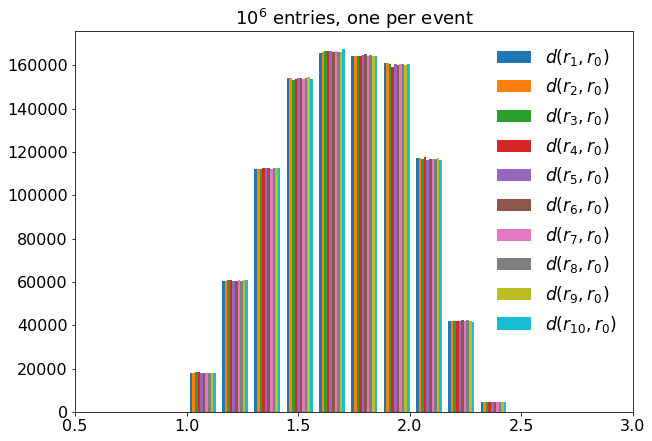

In [15]:
names = ['$d(r_{'+'{}'.format(i)+'},r_0)$' for i in range(1, 11)]
plt.hist(d, label=names)
plt.title('$10^6$ entries, one per event')
plt.xlim(0.5, 3)
plt.legend();

### Distance between $r_i$ and $<r>_{i}$ for each event

Another calculation is to compute the average position for each event and see how distant each vector is from this position. To perform such a calculation, we will use NumPy array broadcasting. Let's first compute the average position for every event:

In [16]:
r_mean = np.mean(r, axis=1)

Now, let's broadcast this array of shape `(1e6, 3)` with the full dataset, i.e. an array of shape `(1e6, 10, 3)`, by computing the distance for each point.

In [17]:
try:
    d_to_mean = np.sum((r-r_mean)**2, axis=2)**0.5
except ValueError:
    print('Impossible for {} and {}'.format(r.shape, r_mean.shape))

Impossible for (1000000, 10, 3) and (1000000, 3)


There is one missing dimension, describing the 10 positions, which has to be created so that the array can be copied 10 times along this dimension.

In [18]:
r_mean_3d = r_mean[:, np.newaxis, :]

We can now retry the operation:

In [19]:
try:
    d_to_mean = np.sum((r-r_mean_3d)**2, axis=2)**0.5
    print('Possible for {} and {}'.format(r.shape, r_mean_3d.shape))
except ValueError:
    print('Impossible for {} and {}'.format(r.shape, r_mean_3d.shape))

Possible for (1000000, 10, 3) and (1000000, 1, 3)


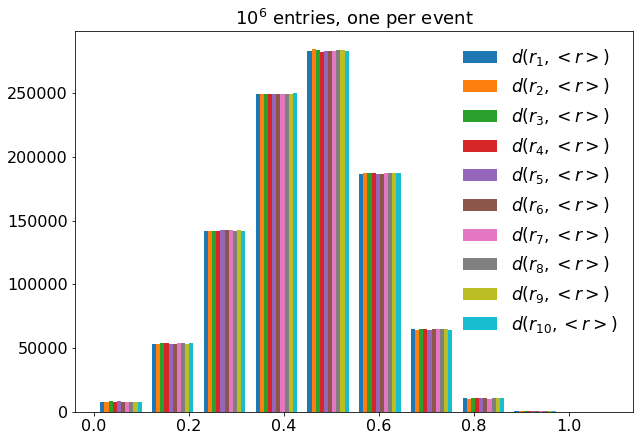

In [20]:
names = ['$d(r_{'+'{}'.format(i)+'},<r>)$' for i in range(1, 11)]
plt.hist(d_to_mean, label=names)
plt.title('$10^6$ entries, one per event')
plt.legend();

## pairing 3d vectors for each observation, without a loop

Being able to pair objects is obviously important for many types of calculations. This allows us to probe correlations at the first order, identify sub-systems, etc. In the traditional way, pairing would involve a *for* loop in which the combinatorics can be done for each event. However, when working with NumPy, we can perform the combinatorics in a vectorized way and return a new NumPy array containing all the pairs. Once this is done, we can perform many types of computations on this new array.

### Finding all possible $(r_{i}, r_{j})$ pairs for all events

One solution to perform this task without a *for* loop was found on [stackoverflow](https://stackoverflow.com/questions/16003217/n-d-version-of-itertools-combinations-in-numpy). The idea is to simply work with indices to build the pairs (since it doesn't really matter what the nature of the objects is), and use NumPy's *fancy* indexing. Let's proceed step by step with a smaller array to understand the procedure (namely 2 observations of 5 positions):

In [21]:
a = r[0:2,0:5]
print(a)

[[[0.01789452 0.66209367 0.06888675]
  [0.39922964 0.87771381 0.01192809]
  [0.88259998 0.88655328 0.30233561]
  [0.53178797 0.69359593 0.05459176]
  [0.69979407 0.82627363 0.63028438]]

 [[0.36893905 0.29645313 0.64392255]
  [0.6084518  0.71718717 0.18079204]
  [0.79397165 0.75437849 0.81858946]
  [0.28424271 0.32153672 0.29690342]
  [0.62484107 0.23856055 0.4057989 ]]]


Since we want to work with the indices of the 5 vectors, we create a NumPy array of integers going from 0 to 4 (`a.shape[1]` is the number of elements along the second dimension, i.e., 5):

In [22]:
array_indices = np.arange(a.shape[1])
print(array_indices)

[0 1 2 3 4]


Then, we use the package `itertools` to deal with combinatorics. This will return an *iterator* that can be turned into a NumPy array using `np.fromiter()`. However, this function requires specifying the data type `dt`, which is done using a structured array syntax here (i.e., `[(varName1, type1), (varName2, type2)]`). For more details on data types, check this [documentation page](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.dtypes.html).

In [23]:
dt = np.dtype([('index1', np.intp), ('index2', np.intp)])
print(dt)

[('index1', '<i8'), ('index2', '<i8')]


In [24]:
array_indice_comb = np.fromiter(itertools.combinations(array_indices, 2), dt)
print(array_indice_comb)

[(0, 1) (0, 2) (0, 3) (0, 4) (1, 2) (1, 3) (1, 4) (2, 3) (2, 4) (3, 4)]


The next step is to format these numbers into an indices array with the proper dimensions, so that when we do `a[indices]`, we get all the pairs. For instance, we need to have all 10 pairs, each with two elements corresponding to a shape `indices.shape=(10,2)`. We can achieve this in two steps:

- `array_indice_comb.view(np.intp)` returns the exact same data as `array_indice_comb`, but as a 1D array of positive integers.
- We reshape the resulting array with `reshape(-1, 2)`, where -1 means "compute the size of the first dimension to have 2 objects (we want pairs!) in the second dimension.

In [25]:
indices = array_indice_comb.view(np.intp).reshape(-1, 2)
print(indices)

[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]]


The final step is to exploit fancy indexing along `axis=1`, i.e., the 5 spatial positions. In practice, for each observation `iobs`, we want to have `a[iobs, indices]`. There are two ways to do this: 
- (a) `a[:, indices]`
- (b) using the NumPy function `np.take(a, indices, axis)` which makes the code more independent from the structure of `a`.

In [26]:
a_pairs = np.take(a, indices, axis=1)
print(a_pairs.shape)

(2, 10, 2, 3)


In [27]:
a_pairs = a[:,indices]
print(a_pairs.shape)

(2, 10, 2, 3)


We now have 2 events, each consisting of 10 pairs. Each pair consists of 2 objects (still a pair!), each with 3 coordinates (spatial positions). We can print all 10 pairs for the first observation:

In [28]:
print(a_pairs[0])

[[[0.01789452 0.66209367 0.06888675]
  [0.39922964 0.87771381 0.01192809]]

 [[0.01789452 0.66209367 0.06888675]
  [0.88259998 0.88655328 0.30233561]]

 [[0.01789452 0.66209367 0.06888675]
  [0.53178797 0.69359593 0.05459176]]

 [[0.01789452 0.66209367 0.06888675]
  [0.69979407 0.82627363 0.63028438]]

 [[0.39922964 0.87771381 0.01192809]
  [0.88259998 0.88655328 0.30233561]]

 [[0.39922964 0.87771381 0.01192809]
  [0.53178797 0.69359593 0.05459176]]

 [[0.39922964 0.87771381 0.01192809]
  [0.69979407 0.82627363 0.63028438]]

 [[0.88259998 0.88655328 0.30233561]
  [0.53178797 0.69359593 0.05459176]]

 [[0.88259998 0.88655328 0.30233561]
  [0.69979407 0.82627363 0.63028438]]

 [[0.53178797 0.69359593 0.05459176]
  [0.69979407 0.82627363 0.63028438]]]


Once understood, we can wrap up this code into a function where we generalize the number of objects we want to group `n` and the axis along which we want to group `axis`:

In [29]:
def combs_nd(a, n, axis=0):
    i = np.arange(a.shape[axis])
    dt = np.dtype([('', np.intp)]*n)
    i = np.fromiter(itertools.combinations(i, n), dt)
    i = i.view(np.intp).reshape(-1, n)
    return np.take(a, i, axis=axis)

As a sanity check, we can recompute `a_pair` and compare it with the previous results.

In [30]:
a_pairs = combs_nd(a=r[0:2,0:5], n=2, axis=1)
print(a_pairs[0])

[[[0.01789452 0.66209367 0.06888675]
  [0.39922964 0.87771381 0.01192809]]

 [[0.01789452 0.66209367 0.06888675]
  [0.88259998 0.88655328 0.30233561]]

 [[0.01789452 0.66209367 0.06888675]
  [0.53178797 0.69359593 0.05459176]]

 [[0.01789452 0.66209367 0.06888675]
  [0.69979407 0.82627363 0.63028438]]

 [[0.39922964 0.87771381 0.01192809]
  [0.88259998 0.88655328 0.30233561]]

 [[0.39922964 0.87771381 0.01192809]
  [0.53178797 0.69359593 0.05459176]]

 [[0.39922964 0.87771381 0.01192809]
  [0.69979407 0.82627363 0.63028438]]

 [[0.88259998 0.88655328 0.30233561]
  [0.53178797 0.69359593 0.05459176]]

 [[0.88259998 0.88655328 0.30233561]
  [0.69979407 0.82627363 0.63028438]]

 [[0.53178797 0.69359593 0.05459176]
  [0.69979407 0.82627363 0.63028438]]]


It can be interesting to see that this operation takes less than a second for a million observations of 10 vectors, meaning 45 pairs.

In [31]:
%timeit combs_nd(a=r, n=2, axis=1)

614 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Computing (minimum) distances on these pairs

Once we have these pairs, we can, for example, compute all the distances and find which pair has the closest objects. Starting with the pairs:

In [32]:
pairs = combs_nd(a=r, n=2, axis=1)

We can then define the vectorial difference between the two positions of a pair and compute the Euclidean distance.

In [33]:
dp = pairs[:, :, 0, :]-pairs[:, :, 1, :]
distances = (np.sum(dp**2, axis=2))**0.5

And get the minimum distance for each event:

In [34]:
smallest_distance = np.min(distances, axis=1)
print(smallest_distance.shape)

(1000000,)


All of these instructions can be put into a function that can be timed:

In [35]:
def compute_dr_min(a):
    pairs = combs_nd(a, 2, axis=1)
    i1 = tuple([None, None, 0, None])
    i2 = tuple([None, None, 1, None])
    return np.min(np.sum((pairs[i1]-pairs[i2])**2, axis=2)**0.5, axis=1)

In [36]:
%timeit compute_dr_min(r)

712 ms ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that performing all operations in the fewest possible number of lines can significantly speed up the process. Let's define another function where the difference between the pair elements is computed separately.

In [37]:
def compute_dr_min_more_steps(a):
    pairs = combs_nd(a, 2, axis=1)
    dp = pairs[:, :, 0, :]-pairs[:, :, 1, :]
    return np.min(np.sum(dp**2, axis=2)**0.5, axis=1)

And let's compare the performance on 0.2 million observations:

In [38]:
%timeit compute_dr_min(a=r[:200000])
%timeit compute_dr_min_more_steps(a=r[:200000])

123 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
561 ms ± 84.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's now plot the distributions of all distances for all the pairs (using the `flatten()` function, which returns a 1D array), and only the pair with the smallest distances.

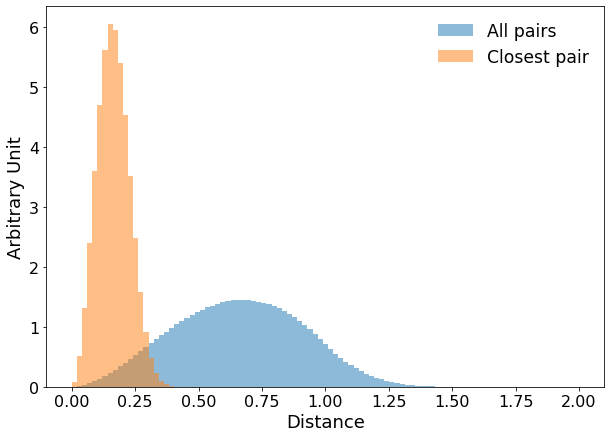

In [39]:
plot_style = {
    'bins': np.linspace(0, 2, 100),
    'alpha': 0.5,
    'density': True,
}

plt.hist(distances.flatten(), label='All pairs' ,**plot_style)
plt.hist(smallest_distance, label='Closest pair', **plot_style)
plt.xlabel('Distance')
plt.ylabel('Arbitrary Unit')
plt.legend();

## Selecting a subset of $r_i$ based on $(x,y,z)$ values, without a loop

The next step in our exploration of "loop-less calculations" is to be able to perform the same kind of computation described above, but only on a subset of positions selected according to a given criteria. For example, we might want to keep particles only if they have a positive charge. Many obvious applications can be found in other physics fields and/or machine learning. Let's start by accessing the three arrays of coordinates in order to select points based on some simple criteria.

In [40]:
x, y, z = r[:, :, 0], r[:, :, 1], r[:, :, 2]

### Counting the number of points among the 10 where $x_i > y_i$ in each event

We will use the numpy masking feature described in the first chapter, defining an index of booleans based on the `x` and `y` arrays:

In [41]:
idx = x > y
print(idx.shape)

(1000000, 10)


We can quickly check the distribution for the selected coordinates: $x$ and $y$ are anti-correlated - as expected - while $z$ is flat - as expected.

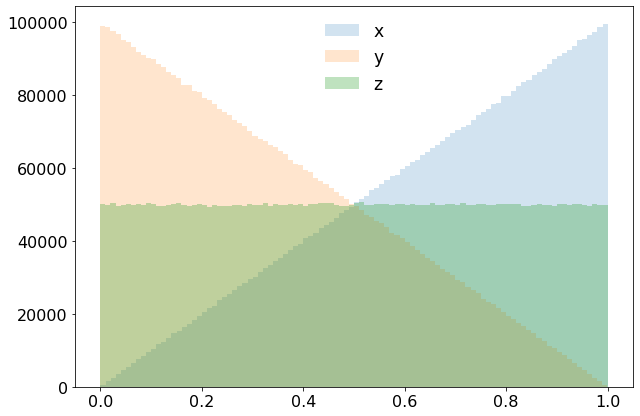

In [42]:
plt.hist(x[idx], bins=100, alpha=0.2, label='x')
plt.hist(y[idx], bins=100, alpha=0.2, label='y')
plt.hist(z[idx], bins=100, alpha=0.3, label='z')
plt.legend();

If we want to better understand how this selection affects our data, one might want to count the number of points per event that satisfy this selection. This can be done by using `np.count_nonzero()` on the boolean array along the axis representing the 10 vectors (`axis=1`):

In [43]:
c = np.count_nonzero(idx, axis=1)
print(c.shape)

(1000000,)


We can then plot the distribution of this number for all the events.

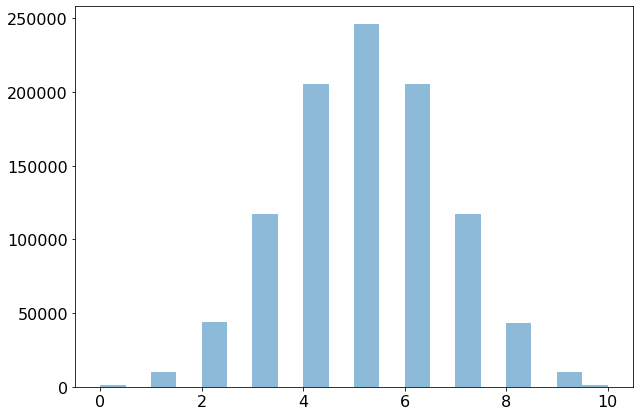

In [44]:
plt.hist(c, bins=20, alpha=0.5);

### Plotting $z$ for the two types of populations ($x>y$ and $x<y$)

This is obviously useful to inspect the different populations - something we want to do very often. For the plotting purpose, let's consider only the first 500 observations that we dump into `sx`, `sy`, `sz` (`s` for small):

In [45]:
sx, sy, sz = x[0:500, ...], y[0:500, ...], z[0:500, ...]

We define the mask computed on these small arrays as `smask`.

In [46]:
smask = sx>sy

And we can plot the result in the 2D plane $(x,y)$ with the $z$ coordinate as the marker size, for instance $1/(z+10^{-3})$. The two populations are defined using both `smask` and `~smask` to ensure that the union of the two is the original dataset.

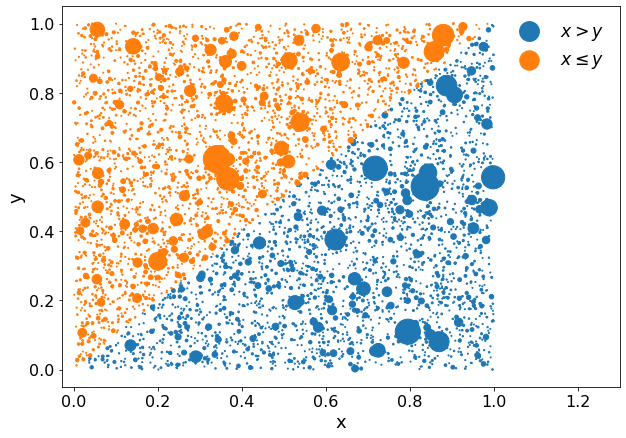

In [47]:
plt.scatter(sx[smask], sy[smask], s=(sz[smask]+1e-3)**-1, label='$x>y$')
plt.scatter(sx[~smask], sy[~smask], s=(sz[~smask]+1e-3)**-1, label='$x\leq y$')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.03, 1.3)
plt.legend();

### Computation of  $x_i+y_i+z_i$ sum over a subset of the 10 positions

Once we are able to isolate a subset of points, we might want to compute new numbers based only on those. This is what is proposed here with the sum of the three coordinates. Let's first compute the sum, called `ht`, over all 10 points:

In [48]:
ht1 = np.sum(x+y+z, axis=1)
print(ht1.shape)

(1000000,)


Apply now a selection, which multiplies the value by 0 (i.e., `False`) if the condition is not satisfied.

In [49]:
selection = x>y
ht2 = np.sum((x+y+z)*selection, axis=1)

Of course, this only works for computations that are not affected by a zero. If we want to compute the product of coordinates, this approach will obviously not work.

In [50]:
prod = np.product((x+y+z)*selection, axis=1)
eff = np.count_nonzero(prod>0)/len(prod)
print('Efficiency of prod>0: {:.5f}'.format(eff))

Efficiency of prod>0: 0.00102


In a more general manner, we should use *masked arrays*, which completely remove the masked elements from any computations.

In [51]:
mx = np.ma.array(x, mask=selection)
my = np.ma.array(y, mask=selection)
mz = np.ma.array(z, mask=selection)
prod = np.product((mx+my+mz), axis=1)
eff = np.count_nonzero(prod>0)/len(prod)
print('Efficiency of prod>0: {:.5f}'.format(eff))

Efficiency of prod>0: 1.00000


Finally, one can plot the result, removing the observation with `ht2==0` (the case where all 10 points have $x\leq y$).

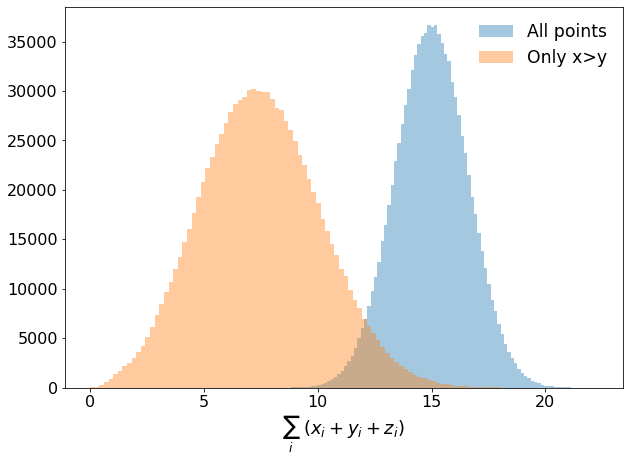

In [52]:
plt.hist(ht1, bins=100, alpha=0.4, label='All points')
plt.hist(ht2[ht2>0], bins=100, alpha=0.4, label='Only x>y')
plt.xlabel('$\sum_{i} \; (x_i+y_i+z_i)$')
plt.legend();

### Pairing with a subset of $r_i$ verifying $x_i > y_i$ only

Another computation would be to redo the pairing on the subset of selected positions. In order to do so, we follow the same logic, except that we will directly replace removed values with `np.nan` in order to easily identify them after the pairing. It's *very important to copy the original data using the `copy` module*, otherwise the original data will be modified in the following piece of code.

In [53]:
import copy
selection = x>y
selected_r = copy.copy(r)
selected_r[selection] = np.nan
print(selected_r[0])

[[0.01789452 0.66209367 0.06888675]
 [0.39922964 0.87771381 0.01192809]
 [0.88259998 0.88655328 0.30233561]
 [0.53178797 0.69359593 0.05459176]
 [0.69979407 0.82627363 0.63028438]
 [0.19121361 0.80913874 0.2813931 ]
 [0.22248198 0.78734303 0.39821198]
 [0.41256443 0.81143611 0.71874392]
 [0.10597153 0.61954029 0.15438807]
 [0.0586176  0.5567407  0.19918271]]


One can now call the pairing function on the filtered dataset.

In [54]:
selected_pairs = combs_nd(selected_r, n=2, axis=1)

And compute the distances, but replace back the `np.nan` with a default value that will not be seen on a plot.

In [55]:
p1, p2 = pairs[:, :, 0, :], pairs[:, :, 1, :]
dp = np.sum((p1-p2)**2, axis=2)**0.5
dp[np.isnan(dp)] = 999

And plotting the distributions of both all distances and minimum distances for pairs made out of points verifying $x>y$:

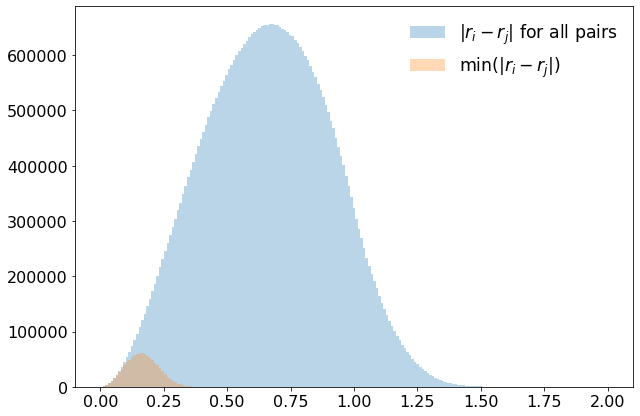

In [56]:
plot_style = {'bins': np.linspace(0, 2, 200), 'alpha':0.3}
plt.hist(dp.flatten(), label='$|r_i-r_j|$ for all pairs', **plot_style)
plt.hist(np.min(dp, axis=1), label='min$(|r_i-r_j|)$', **plot_style)
plt.legend();

## Some comments

Manipulating numpy arrays is quite powerful and fast for both computation and plotting, provided that we use numpy optimizations, namely vectorization, indexing, and broadcasting. However, there are some limitations to consider, as we saw above. In some cases, we need to use "patchwork approaches" to achieve our desired results without using loops, as we did in the last two sections. What works for one computation may not work for another (for example, replacing rejected values with 0 works for addition but not for multiplication). Additionally, when pairing values, we had to replace all rejected values with `np.nan` in order to filter them later on. This kind of practice can make the code less readable as complexity increases, in my opinion. Perhaps there are smarter ways to accomplish these tasks.